## Proyecto 1

In [209]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn import linear_model

In [210]:
class RegresionLineal:
    def __init__(self, df):
        self.df = pd.DataFrame(np.load(df), columns= ['SalePrice', 'OverallQual', '1stFlrSF', 'TotRmsAbvGrd', 'YearBuilt', 'LotFrontage']) #carga de datos
        self.df= self.df.sample(frac=1, ignore_index=True)
        filas = len(self.df) # mezclamos la data para evitar sesgos
        slicing = int(filas*0.8) # determinamos el 80% del dataframe
        self.df_entre = self.df[:slicing] # dataframe de entrenamiento 80%
        self.df_prueba = self.df[slicing:] # dataframe de prueba 20%

    def analisis(self): # análisis exploratorio
        analisisExp = self.df_entre
        analisisExp = analisisExp.describe().loc[['mean','max', 'min', 'std'],:] # extraemos las columnas deseadas
        analisisExp = analisisExp.rename(index={'mean': 'Media','max':'Máximo', 'min':'Mínimo', 'std': 'Desviación estándar'}) # renombramos la columnas

        rango = pd.DataFrame({ # generamos los rangos restando los máximos y mínimos
            'SalePrice': [analisisExp['SalePrice'].max() - analisisExp['SalePrice'].min()],
            'OverallQual': [analisisExp['OverallQual'].max() - analisisExp['OverallQual'].min()],
            '1stFlrSF': [analisisExp['1stFlrSF'].max() - analisisExp['1stFlrSF'].min()],
            'TotRmsAbvGrd': [analisisExp['TotRmsAbvGrd'].max() - analisisExp['TotRmsAbvGrd'].min()],
            'YearBuilt': [analisisExp['YearBuilt'].max() - analisisExp['YearBuilt'].min()],
            'LotFrontage': [analisisExp['LotFrontage'].max() - analisisExp['LotFrontage'].min()]},
            index= ['Rango'])

        analisisExp = pd.concat([analisisExp, rango]) # concatenamos la nueva columna
        analisisExp = analisisExp.loc[['Media','Máximo', 'Mínimo', 'Rango', 'Desviación estándar'],:] #cambiamos el orden de las columnas
        return analisisExp
    
    def histogramas(self): # función que grafica los histogramas
        for columna in self.df_entre.columns:
            sb.histplot(self.df_entre[columna], color='green').set(title=f'Histograma de {columna}', xlabel=columna, ylabel='Frecuencia')
            plt.show()

    def correlacion(self): # función que grafica la correlación
        corr = self.df_entre.corr() #correlacion
        mask = np.zeros_like(corr, dtype=bool) #mascara para ocultar los datos duplicados en el mapa de calor
        mask[np.triu_indices_from(mask)] = True
        f, ax = plt.subplots(figsize=(9, 7)) # resize de la gráfica
        sb.heatmap(corr, annot=True, cmap='Greens', mask=mask, vmax=0.85, vmin=0, square=True, linewidths=.8).set_title('Correlación entre columnas')
        plt.show()
        correlaciones = corr.unstack().sort_values(ascending=False) # obtenemos todos los pares de correlaciones de forma descendente para obtener las correlaciones más altas
        correlaciones = correlaciones[correlaciones != 1.0] # filtramos las correlaciones que son 1, es decir la correlación entre las mismas columnas
        correlaciones = correlaciones.iloc[[0,2]] # de los pares, obtenemos los que están en la posición 0 y 2. Ya que la posción 1 y 3 son las mismas correlaciones --
                                                  # -- pero en diferente combinación de las mismas columnas
        corr1, corr2 = correlaciones.index.tolist()  # guardamos los pares en variables 
        print("Las dos correlaciones más altas son:")
        print(corr1, ' y ', corr2)

    def scatterplot(self):
        cols = self.df_entre.columns
        for i, a in enumerate(cols): #iteración de columna a
            for j, b in enumerate(cols): #iteración de columna b
                if i >= j: #condición para evitar gráficas duplicadas
                    continue
                x = self.df_entre[a]
                y = self.df_entre[b]
                corr = round(x.corr(y), 2)
                title = f'Scatterplot de {a} vs {b} (Correlación: {corr})'

                plt.figure()
                plt.scatter(x, y, c='green', s=10,marker='.')
                plt.title(title)
                plt.xlabel(a)
                plt.ylabel(b)
                plt.show()

    def regresion_lineal(self, independiente, dependiente, epochs:int, imprimir_error_cada:int, rate:float):
        x = self.df_entre[independiente]
        x = x.values
        y = self.df_entre[dependiente]
        y = y.values

        # Creamos la matriz x1 con una columna con el vector x otra llena de 1s
        x1 = np.hstack((x.reshape(-1, 1), np.ones_like(x.reshape(-1, 1))))
    
        # Inicializamos en 0 los parámetros donde betas = [b1, b0]
        betas = np.zeros((2,1))
        n = len(y)

        # Creamos una lista vacía para almacenar el error en cada iteración
        error = []
        self.error = error

        # Creamos listas para almacenar yPrima y el número de iteración
        index = []
        self.index = index

        yPrima = []
        self.yPrima = yPrima

        for i in range(epochs):
            # Calculamos las predicciones del modelo para todos los datos de la forma y' = x*b1 + b0
            y1 = np.dot(x1, betas)
            yPrima.append(y1)

            # Calculamos el error cuadrádito medio entre las predicciones y los valores reales
            costo = np.sum((y.reshape(-1,1) - y1) ** 2) / (2 * n)
        
            # Almacenamos el error en la lista
            error.append(costo)
        
            # Imprimimos el error con el número de iteración
            if (i+1) % imprimir_error_cada == 0:
                print(f"El error en el epoch {i+1} es de {costo}")
        
            # Obtenemos los gradientes donde gradiente = [gb1, gb0]
            gradientes = np.dot(x1.T, (y1 - y.reshape(-1, 1))) / n

            # Actualizamos b1 y b0
            betas = betas - np.dot(gradientes, rate)
            self.betasFin = betas
            index.append(i)
        
    def graficarError(self): # graficamos el error
        x = self.index
        y = self.error
        plt.plot(x, y, color='green')
        plt.title('Error por número de iteración')
        plt.xlabel('Iteración')
        plt.ylabel('Error')
        plt.show()

    def graficarModelo(self, independiente, dependiente, n): # graficamos la evolución del modelo en el tiempo
        x = self.df_entre[independiente]
        x = x.values
        self.x = x
        y = self.df_entre[dependiente]
        y = y.values
        self.y = y

        for i in range(len(self.yPrima)):
            if (i+1) % n == 0:
                plt.figure()
                plt.scatter(x, y, c='green', s=10,marker='.')
                plt.plot(x, self.yPrima[i], c='red', linewidth= 2)
                plt.title(f'Regresión lineal Iteración No. {i+1}')
                plt.xlabel(independiente)
                plt.ylabel(dependiente)
                plt.show()

    def regresion_scikit(self, independiente, dependiente): # graficamos el modelo de regresión con sickit-learn
        x = self.df_entre[independiente]
        x = x.values.reshape(-1,1)
        y = self.df_entre[dependiente]
        y = y.values.reshape(-1,1)

        regresion = linear_model.LinearRegression()
        regresion.fit(x, y)
        yPred = regresion.predict(x)
        self.yPred = yPred
        betasPred = [regresion.coef_, regresion.intercept_] # guardamos las betas b1 y b0 obtenidas por scikit-learn
        self.betasPred = betasPred

        plt.scatter(x, y, c='green', s=10,marker='.')
        plt.plot(x, yPred, c='orange', linewidth= 2)
        plt.title('Regresión lineal con Scikit-learn')
        plt.xlabel(independiente)
        plt.ylabel(dependiente)       
        plt.show()

    def comparacion(self):
        ymodelo = self.yPrima[-1]
        yscikit = self.yPred
        yPromedio = (ymodelo + yscikit) / 2
        plt.scatter(self.x, self.y, c='green', s=10,marker='.')
        plt.plot(self.x, ymodelo, c='red', linewidth= 1, linestyle= 'solid', label='Modelo manual')
        plt.plot(self.x, yscikit, c='orange', linewidth= 1, linestyle= 'dashed', label='Modelo scikit-learn')
        plt.plot(self.x, yPromedio, c='blue', linewidth= 1, linestyle= 'dotted', label='Modelo promedio')
        plt.title('Comparación de modelos')
        plt.legend()
        plt.show()

    def validacion(self, independiente, dependiente):
        x = self.df_prueba[independiente]
        x = x.values.reshape(-1,1)
        y = self.df_prueba[dependiente]
        y = y.values.reshape(-1,1)
        n = len(y)

        # Predicción con el modelo manual
        ymodelo = x*self.betasFin[0] + self.betasFin[1]
        yscikit = x*self.betasPred[0] + self.betasPred[1]
        yPromedio = (ymodelo + yscikit) / 2

        # Calculamos el error cuadrádito medio entre las y de prueba
        errmodelo = np.sum((y - ymodelo) ** 2) / (2 * n)
        errscikit = np.sum((y - yscikit) ** 2) / (2 * n)
        errpromedio = np.sum((y - yPromedio) ** 2) / (2 * n)

        # Gráfica de comparación entre errores
        modelos = [errmodelo, errscikit, errpromedio]
        nombres = ['Error Manual', 'Error Scikit-learn', 'Error Promedio']
        sb.barplot(x= nombres, y=modelos, edgecolor='black', linewidth=1.5, palette='Greens')
        plt.title('Comparación de errores')
        plt.ylabel('Error') 
        plt.show()

        # Gráfica de comparación entre modelos
        plt.scatter(x, y, c='green', s=10,marker='.')
        plt.plot(x, ymodelo, c='red', linewidth= 1, linestyle= 'solid', label='Modelo manual')
        plt.plot(x, yscikit, c='orange', linewidth= 1, linestyle= 'dashed', label='Modelo scikit-learn')
        plt.plot(x, yPromedio, c='blue', linewidth= 1, linestyle= 'dotted', label='Modelo promedio')
        plt.title('Validación de modelos')
        plt.legend()
        plt.show()

        menor = np.argmin(modelos)
        print(f'El error más bajo es el {nombres[menor]}')

In [211]:
df = RegresionLineal('proyecto_training_data.npy')

In [212]:
df.analisis()

,SalePrice,OverallQual,1stFlrSF,TotRmsAbvGrd,YearBuilt,LotFrontage
Media,181137.930651,6.089041,1159.257705,6.517123,1970.672945,70.383648
Máximo,755000.000000,10.000000,3228.000000,14.000000,2010.000000,313.000000
Mínimo,34900.000000,1.000000,372.000000,3.000000,1875.000000,21.000000
Rango,720100.000000,9.000000,2856.000000,12.417194,1979.859355,292.000000
Desviación estándar,79994.288171,1.375119,378.928586,1.582806,30.140645,23.412887


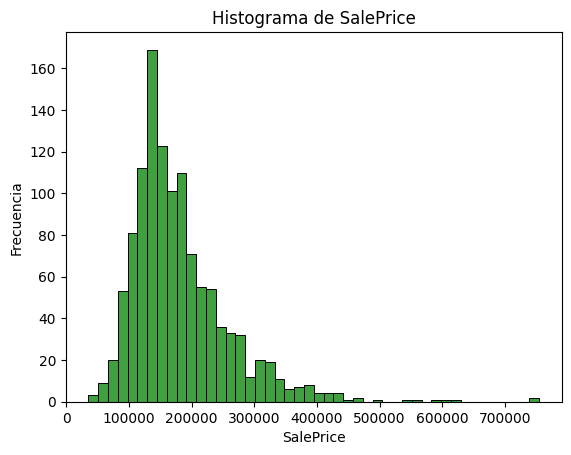

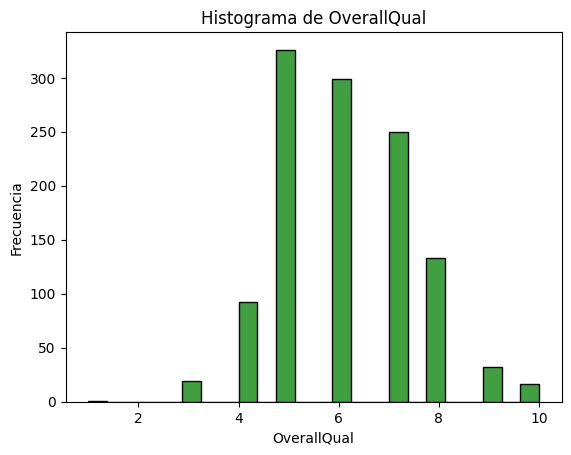

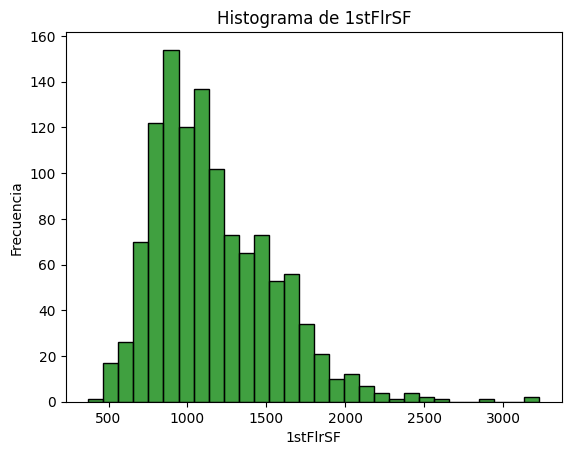

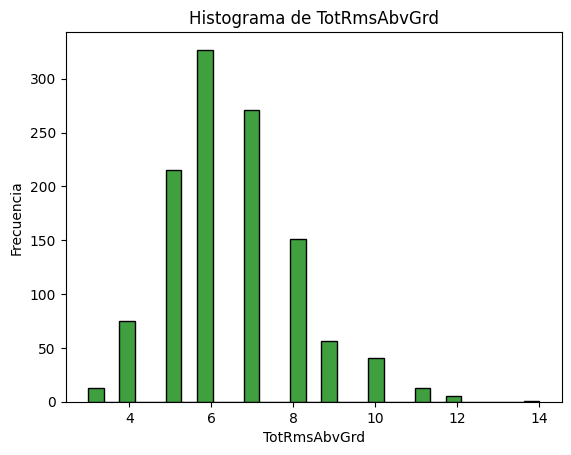

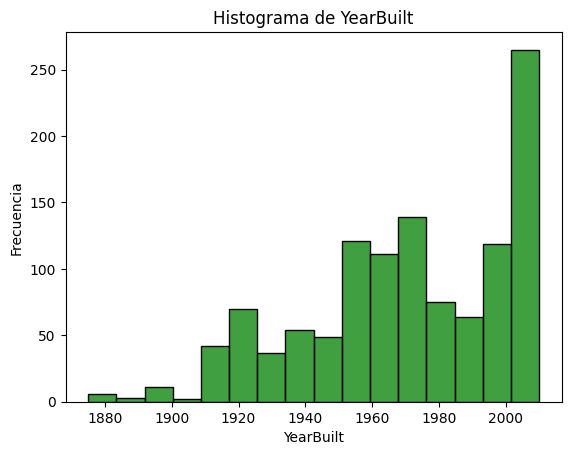

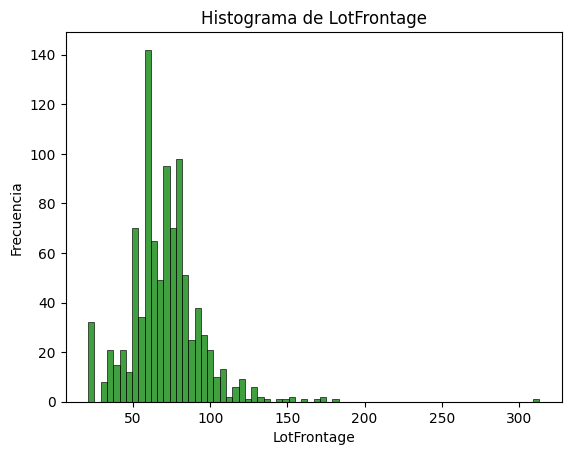

In [213]:
df.histogramas()

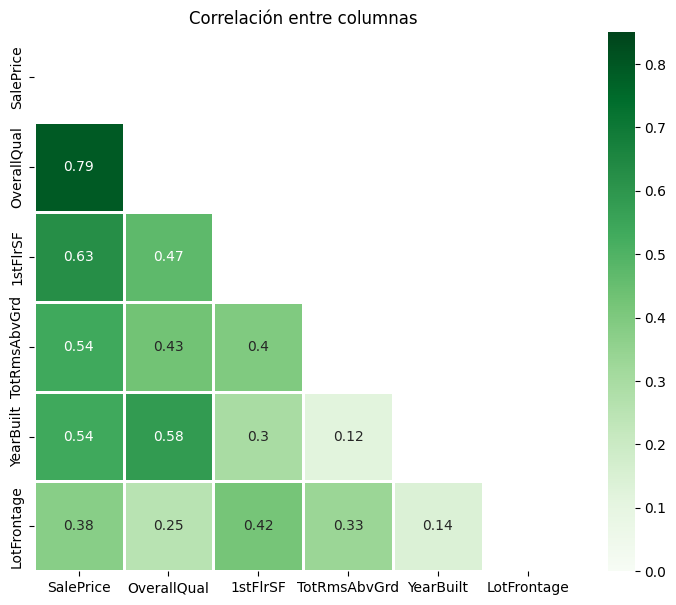

Las dos correlaciones más altas son:
('OverallQual', 'SalePrice')  y  ('1stFlrSF', 'SalePrice')


In [214]:
df.correlacion()

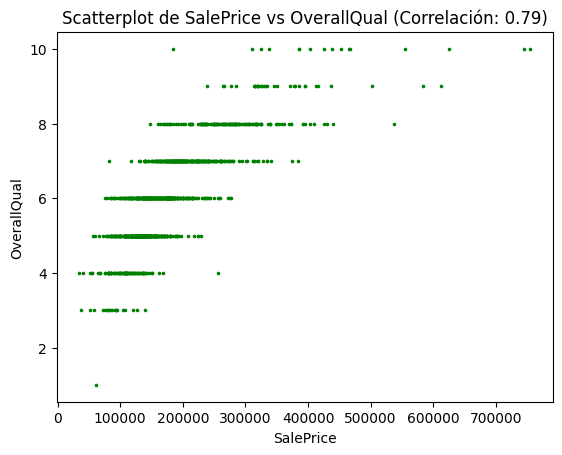

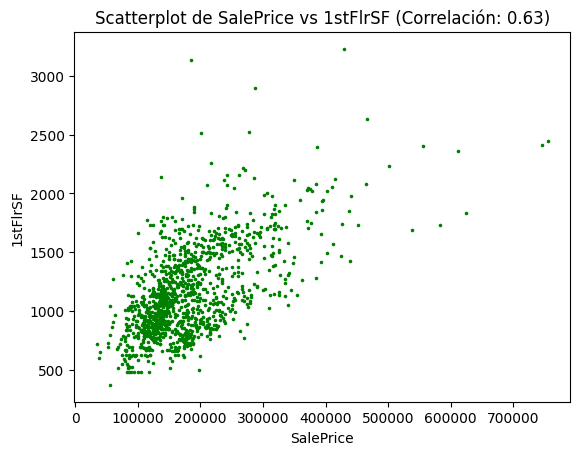

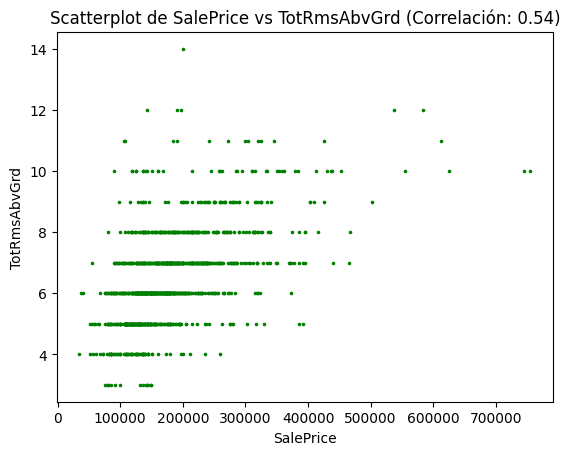

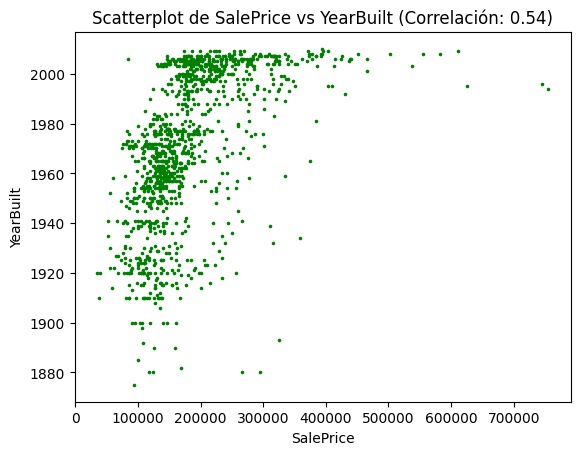

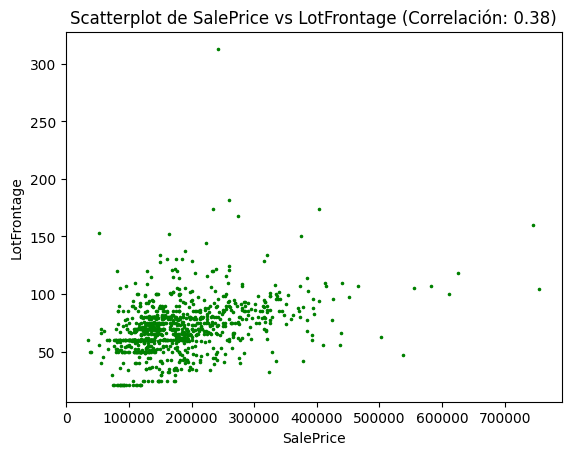

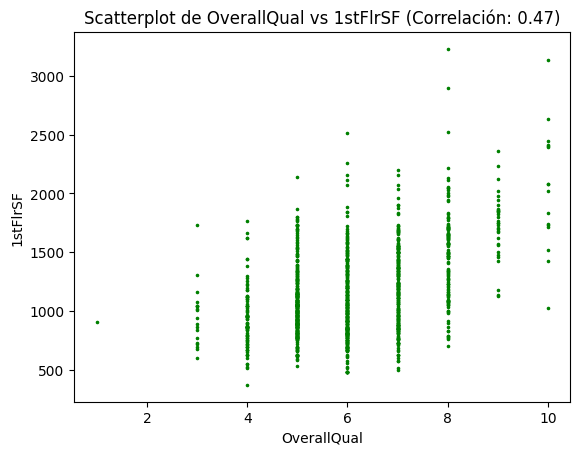

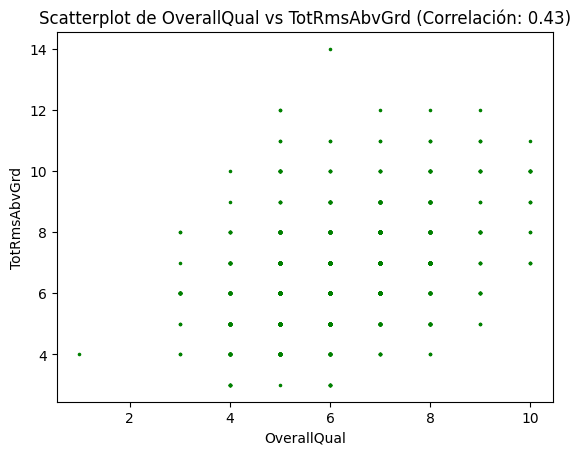

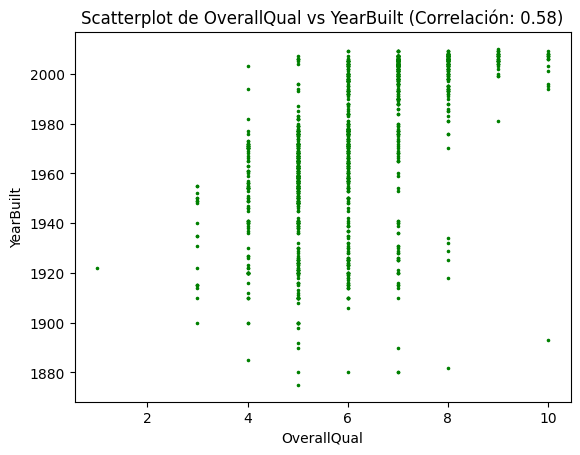

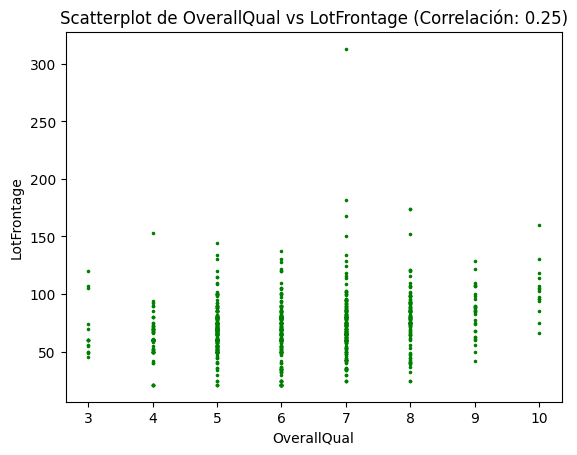

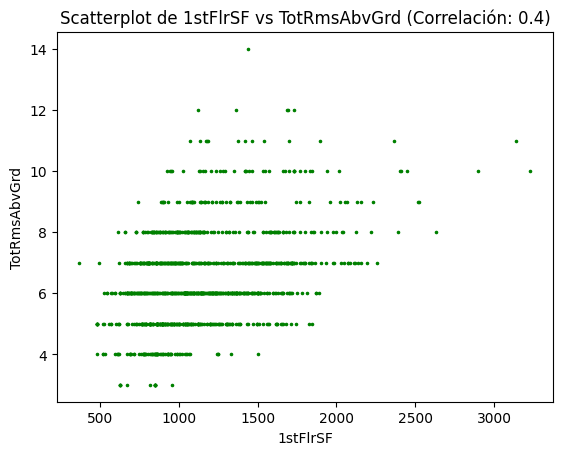

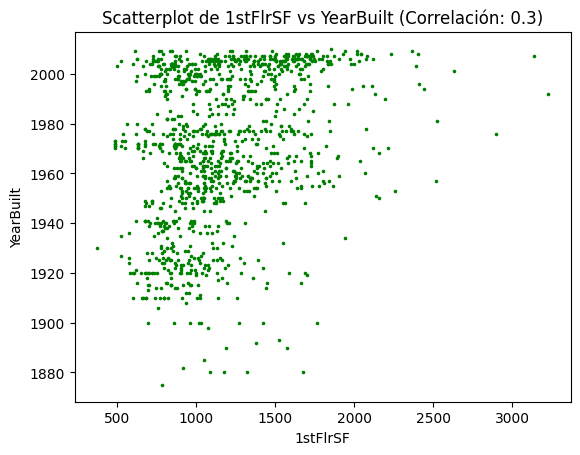

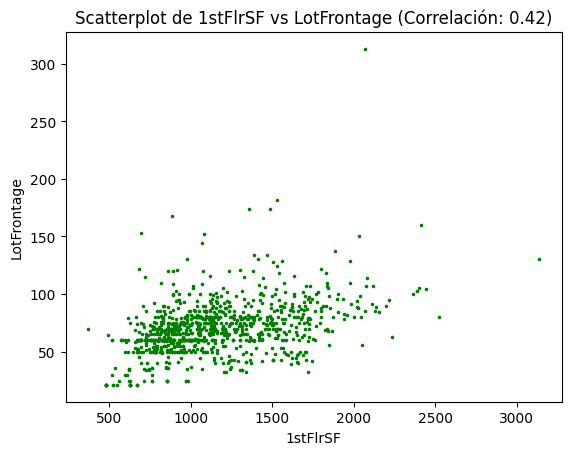

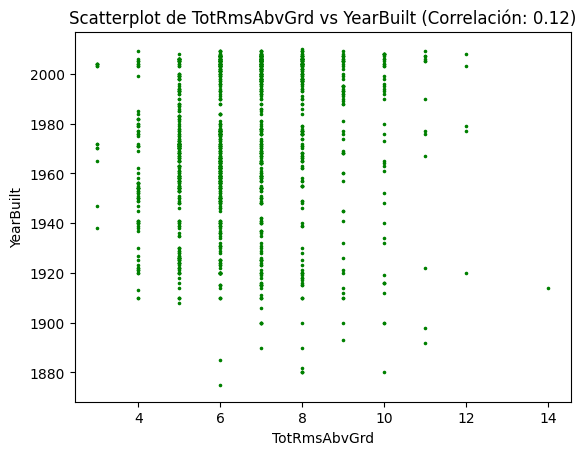

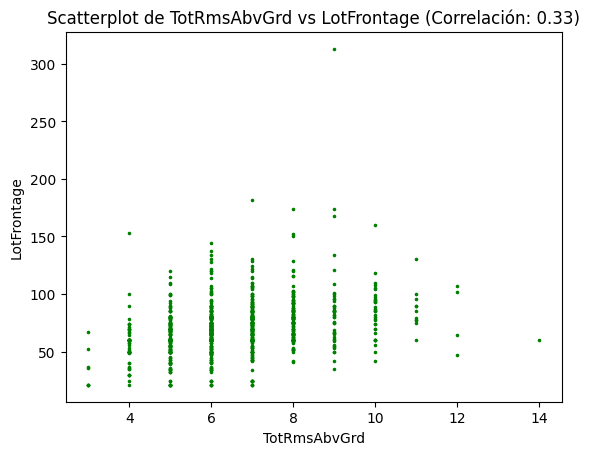

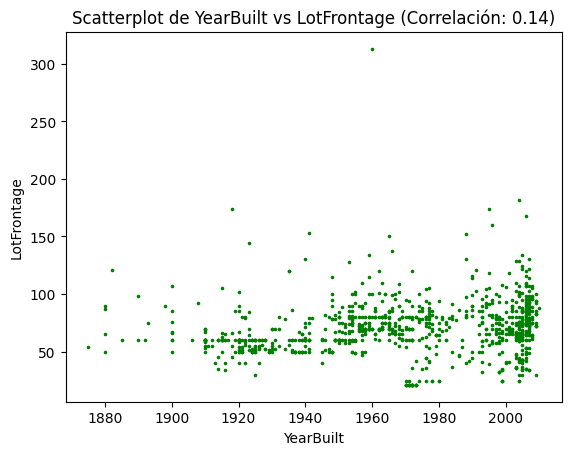

In [215]:
df.scatterplot()

In [219]:
df.regresion_lineal('OverallQual', 'SalePrice', 10000, 1000, 0.01)

El error en el epoch 1000 es de 1290546416.3606467
El error en el epoch 2000 es de 1227858307.9147651
El error en el epoch 3000 es de 1203537039.4537637
El error en el epoch 4000 es de 1194101053.6788423
El error en el epoch 5000 es de 1190440149.7384377
El error en el epoch 6000 es de 1189019819.316099
El error en el epoch 7000 es de 1188468770.0284204
El error en el epoch 8000 es de 1188254978.0032163
El error en el epoch 9000 es de 1188172032.5552084
El error en el epoch 10000 es de 1188139851.9940357


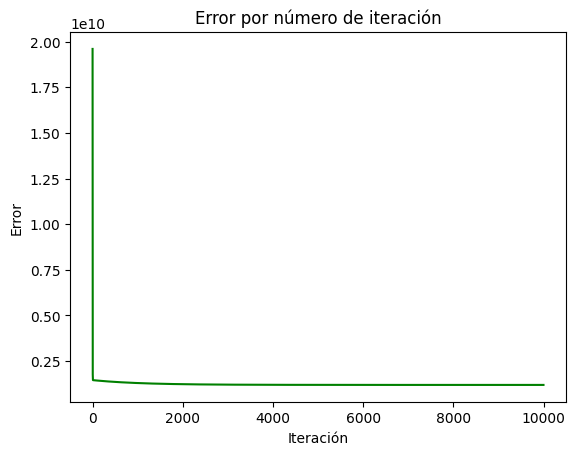

In [220]:
df.graficarError()

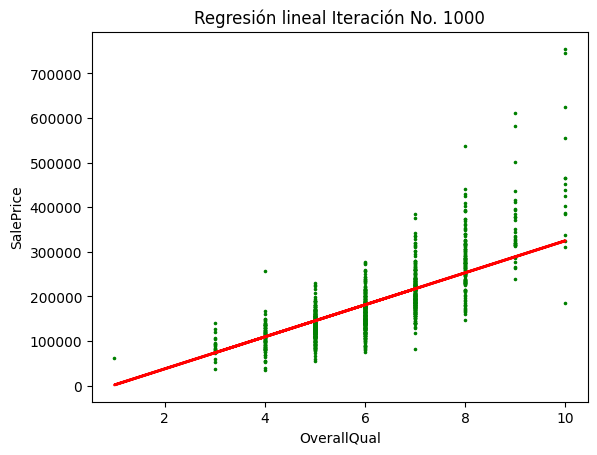

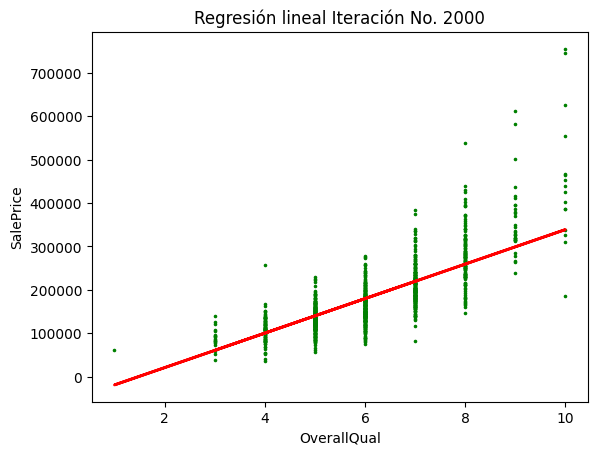

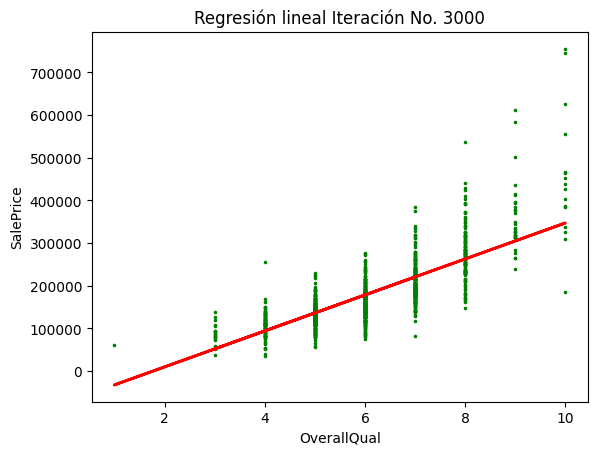

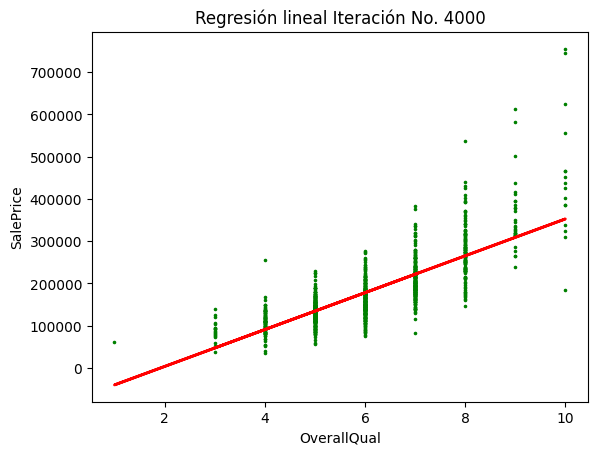

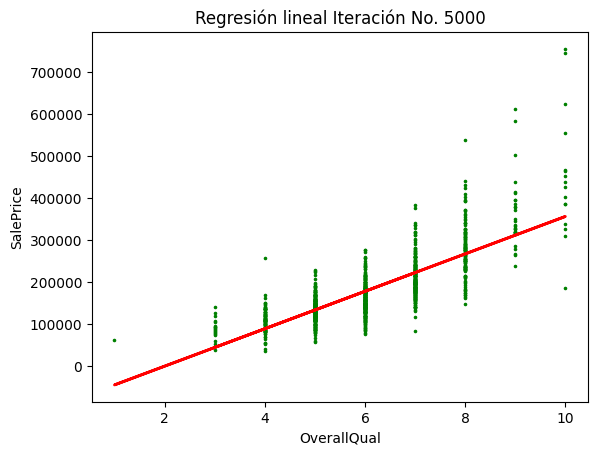

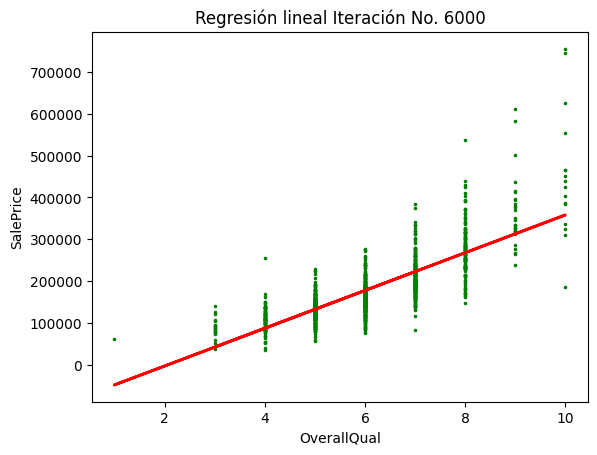

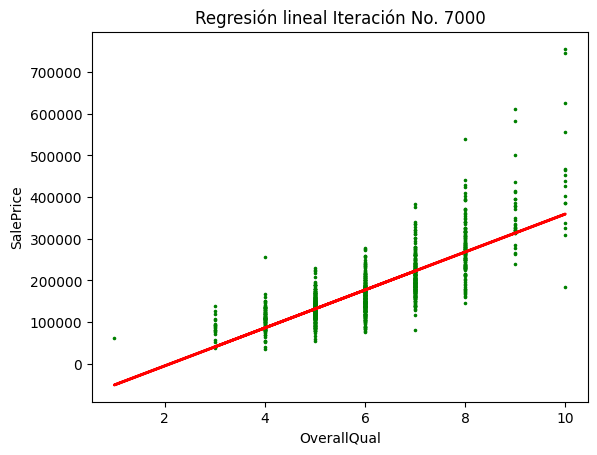

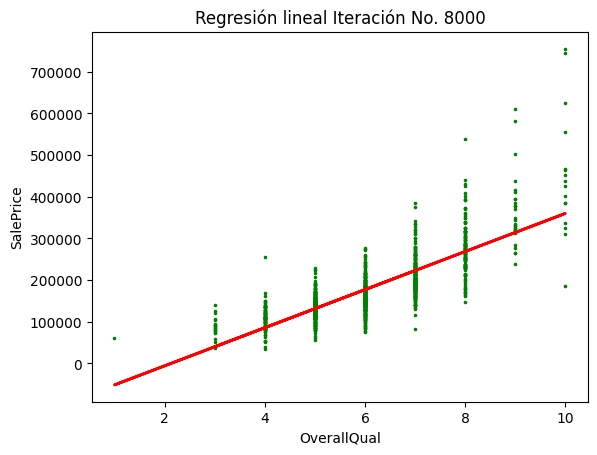

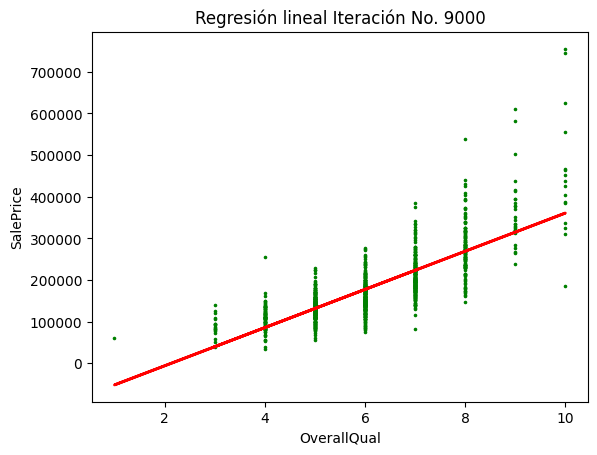

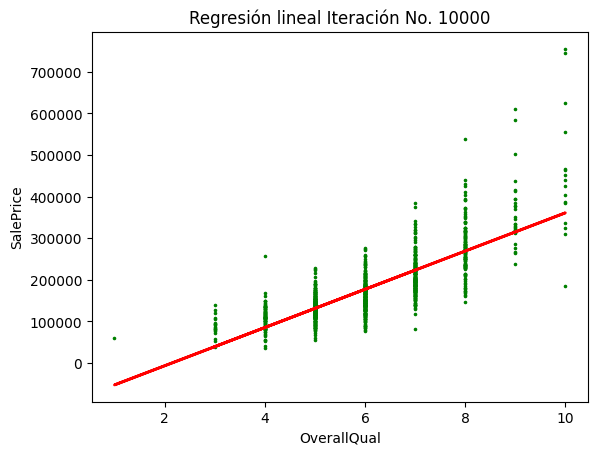

In [221]:
df.graficarModelo('OverallQual', 'SalePrice', 1000)

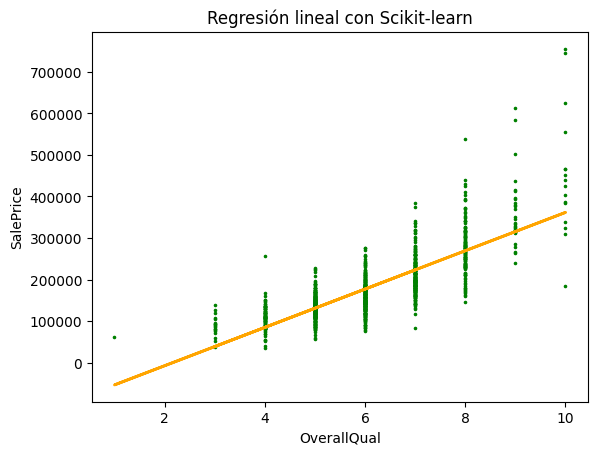

In [222]:
df.regresion_scikit('OverallQual', 'SalePrice')

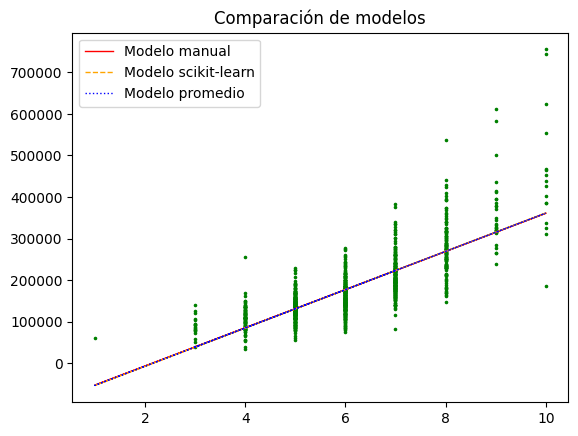

In [223]:
df.comparacion()

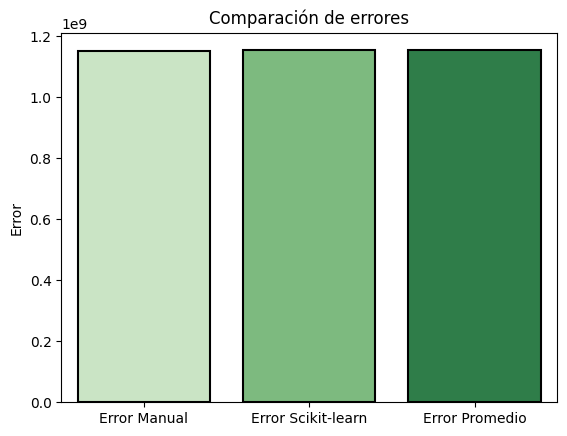

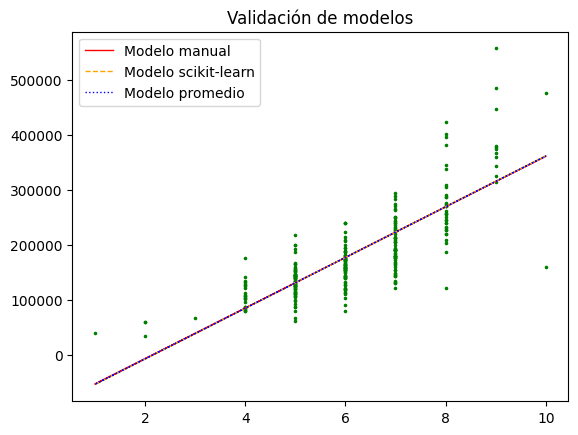

El error más bajo es el Error Manual


In [224]:
df.validacion('OverallQual', 'SalePrice')

In [225]:
df.regresion_lineal('1stFlrSF', 'SalePrice', 50, 5, 0.0000001)

El error en el epoch 5 es de 6839495645.006238
El error en el epoch 10 es de 2951152750.158963
El error en el epoch 15 es de 2174162145.7638535
El error en el epoch 20 es de 2018899499.2762585
El error en el epoch 25 es de 1987874038.9247513
El error en el epoch 30 es de 1981674353.6131191
El error en el epoch 35 es de 1980435494.6490462
El error en el epoch 40 es de 1980187935.977154
El error en el epoch 45 es de 1980138464.5190513
El error en el epoch 50 es de 1980128575.9649143


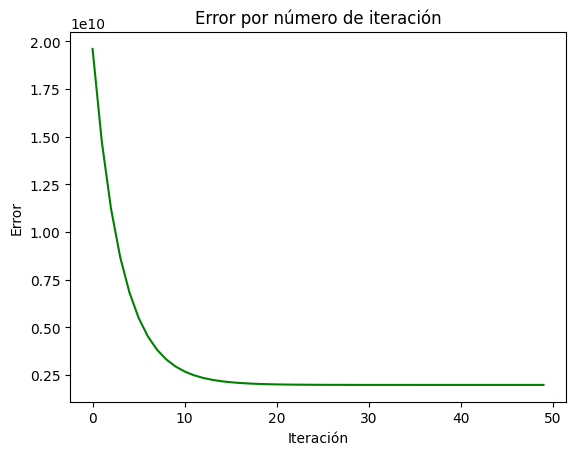

In [226]:
df.graficarError()

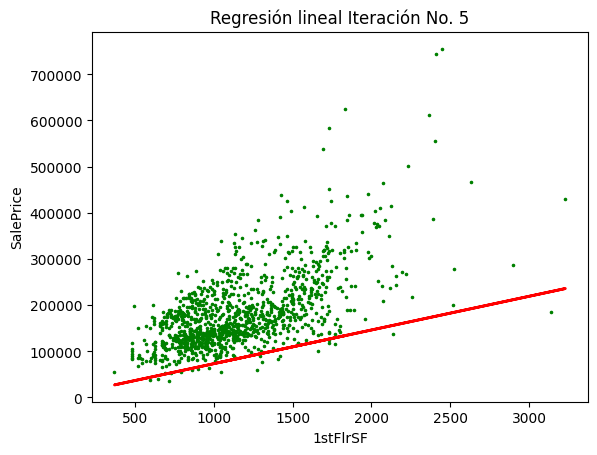

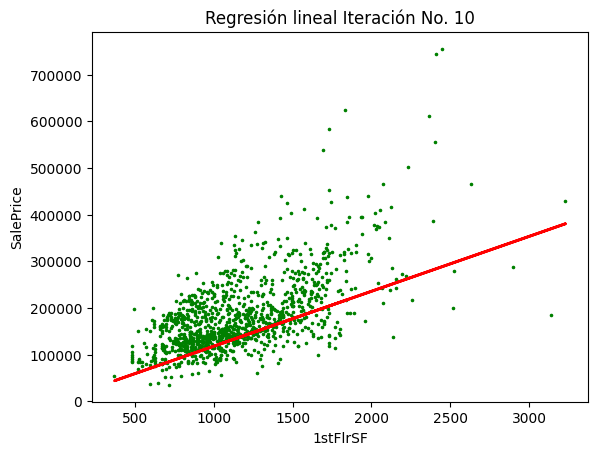

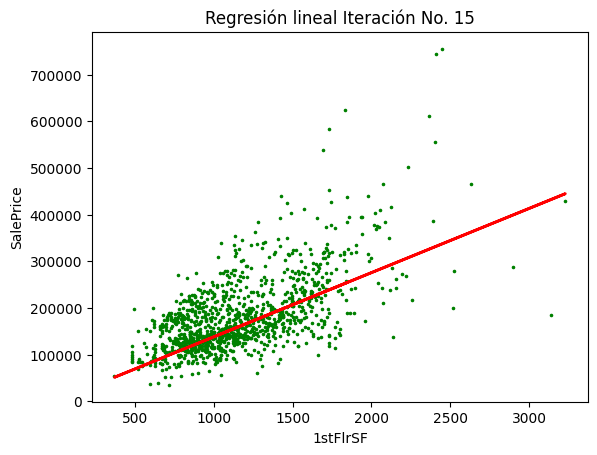

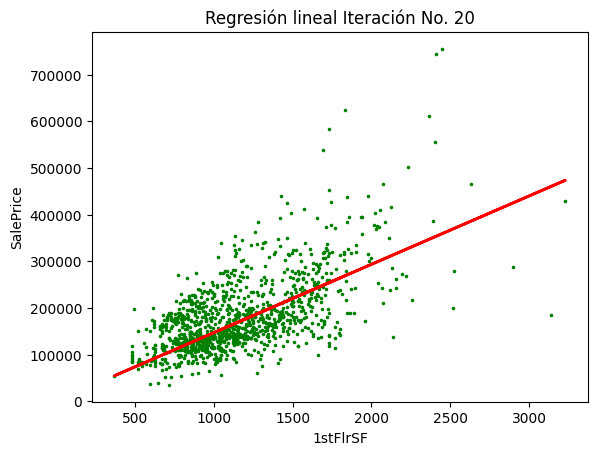

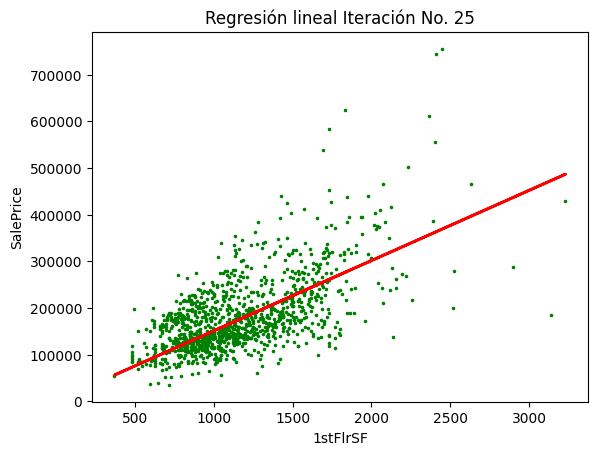

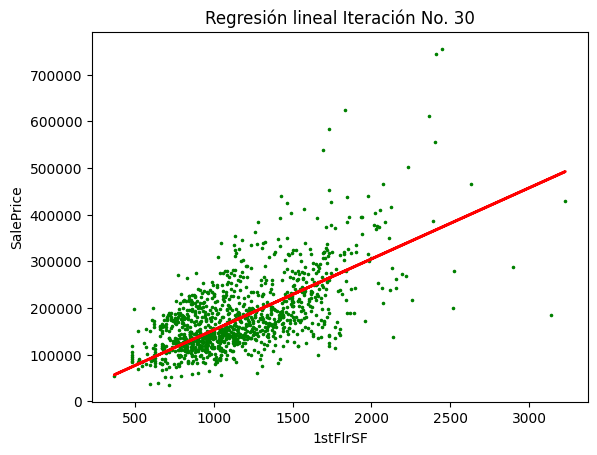

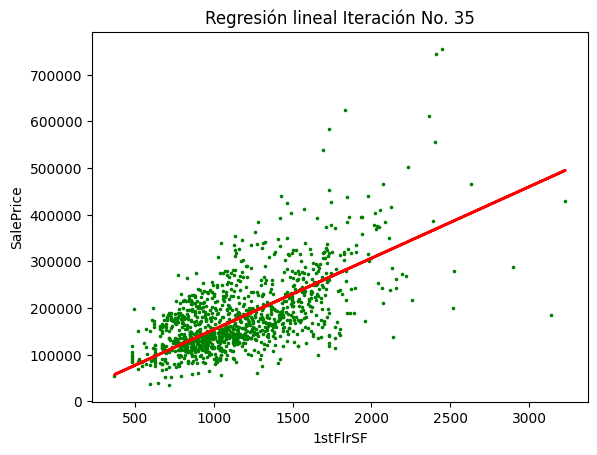

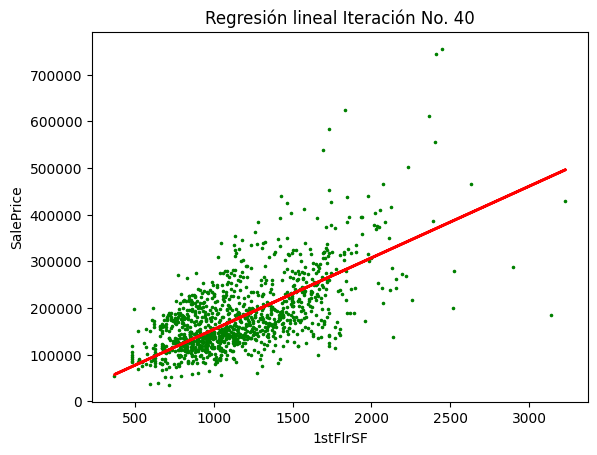

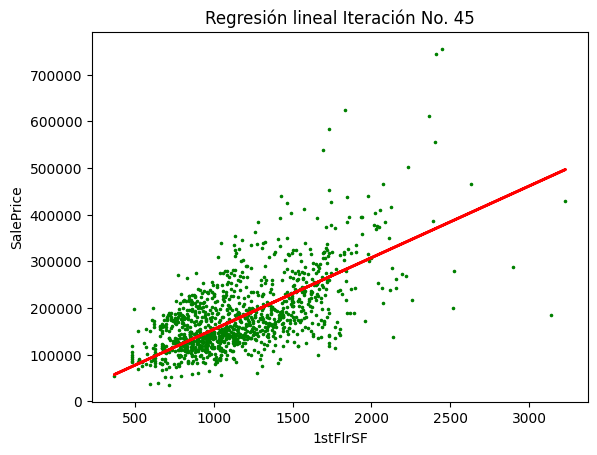

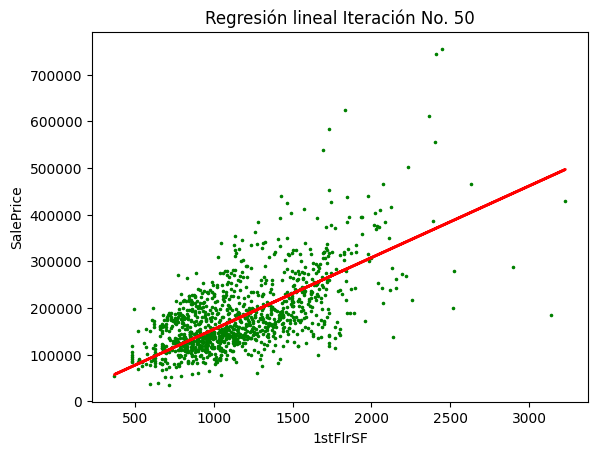

In [227]:
df.graficarModelo('1stFlrSF', 'SalePrice',5)

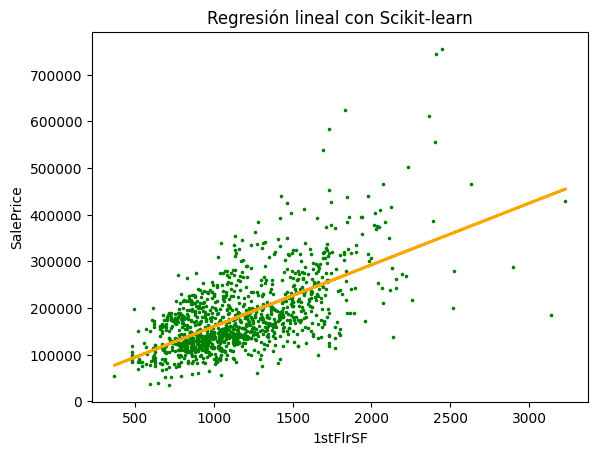

In [228]:
df.regresion_scikit('1stFlrSF', 'SalePrice')

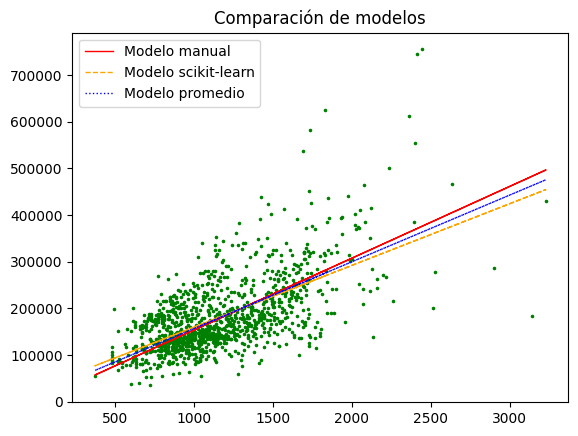

In [229]:
df.comparacion()

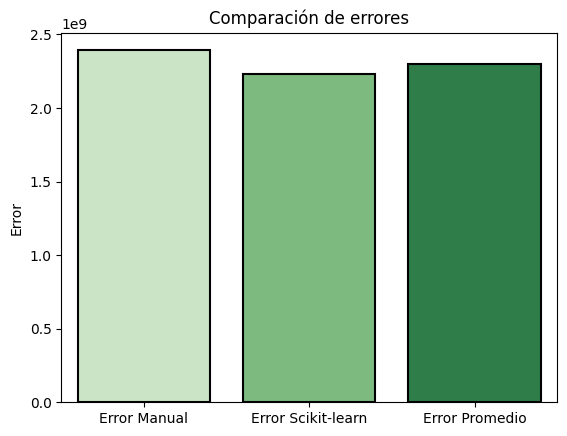

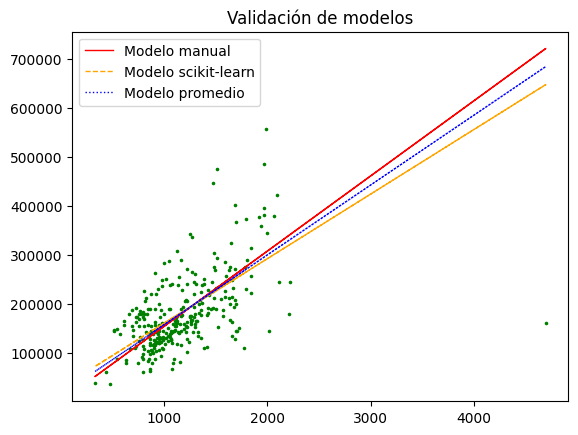

El error más bajo es el Error Scikit-learn


In [230]:
df.validacion('1stFlrSF', 'SalePrice')